# Imports

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from numpy.lib.stride_tricks import sliding_window_view

import glob
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from plot_cm import plot_cm
from copy import deepcopy

from typing import List
import random

from scipy import signal
from s4_model import S4Model

from torchaudio.transforms import Spectrogram, SpecAugment, AmplitudeToDB
from torchvision.transforms import v2

# Settings

In [2]:
# sampling freq
fs = 100

# learning rate
lr = 1e-3
windows = (1, 1)

# number of classes
num_classes = 2

# number of channels
num_channels = 201

# batch size
batch_size = 64

# CNN
in_channels = [num_channels] + [128]
kernel_size = [3]

# model
num_layers = 6
d_model = in_channels[-1]
d_state = 64

# set seeds
torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)
random.seed(0)

# set device and algo
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Model

In [3]:
model = S4Model(
    in_channels=in_channels,
    kernel_size=kernel_size,
    d_output=num_classes,
    d_model=d_model,
    n_layers=num_layers,
    prenorm=True,
    lr=lr
    
)

Constructing S4 (H, N, L) = (128, 32, None)
Constructing S4 (H, N, L) = (128, 32, None)
Constructing S4 (H, N, L) = (128, 32, None)
Constructing S4 (H, N, L) = (128, 32, None)
Constructing S4 (H, N, L) = (128, 32, None)
Constructing S4 (H, N, L) = (128, 32, None)


# Data Loading

## Filtering

In [5]:
# Filter specifications
lowcut = 5.
highcut = 35.
fs = 100  # Sampling frequency
order = 2  # Filter order

# Normalize the frequencies
nyq = 0.5 * fs
low = lowcut / nyq
high = highcut / nyq

# Design the filter
filt_b, filt_a = signal.butter(order, [low, high], btype='band')

## Continous Files

In [6]:
# paths to train-val files
files_train_val = sorted(glob.glob("data/*.npy"))
files_train_val = [path for path in files_train_val if "x" not in path]

# paths to test files
files_test = sorted(glob.glob("data/x*.npy"))

## To Disk

In [7]:
# copy first and last segments
def get_all(paths, type) -> np.ndarray:
    data_all = []
    labels_all = []
    paths_all = []
    for path in paths:
        # load data
        data = np.load(path)
        # load labels
        labels = np.load(path.replace("data", "labels"))
        # make length a factor of 1 minute
        data = data[:data.shape[0] // (fs * 60) * (fs * 60)]
        # trim data
        if data.shape[0] / (fs * 60) > labels.shape[0]:
            data = data[:fs * 60 * labels.shape[0]]
        else:
            labels = labels[:data.shape[0] // (fs * 60)]
        # filter data
        data = signal.filtfilt(filt_b, filt_a, data)
        # normalize
        data = (data - data.mean()) / data.std()
        if type == "test":
            # dublicate first and last segments
            data = np.concatenate([data[:fs*60], data, data[-fs*60:]])
        else:
            labels = labels[windows[0]:-windows[1]]
        # windowing
        data = sliding_window_view(data, fs * 60 * (sum(windows) + 1))[::60 * fs]
        # map label
        labels = [0 if label == 'N' else 1 for label in labels]
        # append
        data_all.append(data)
        labels_all += labels
        paths_all += [os.path.basename(path)[:-4]] * len(labels)
    data_all = np.concatenate(data_all, axis=0)
    return data_all, labels_all, paths_all

In [8]:
def save_segments(data, label, folder, path, i):
    # save path
    save_path = f"segments/{folder}/{path}_{i:05}_{label}_.npy"
    # save
    np.save(save_path, data)    

In [9]:
# from concurrent.futures import ProcessPoolExecutor

# # get files
# data_train_val, labels_train_val, paths = get_all(files_train_val, "train")

# if __name__ == "__main__":
#     # execute with context menager
#     with ProcessPoolExecutor(max_workers=4) as executor:
#         results = executor.map(
#             save_segments, 
#             [data_train_val[i] for i in range(data_train_val.shape[0])], 
#             labels_train_val, 
#             ["train_val"] * len(labels_train_val), 
#             paths, np.arange(len(labels_train_val))
#         )

# # get files
# data_test, labels_test, paths = get_all(files_test, "test")

# if __name__ == "__main__":
#     # execute with context menager
#     with ProcessPoolExecutor(max_workers=4) as executor:
#         results = executor.map(
#             save_segments, 
#             [data_test[i] for i in range(data_test.shape[0])], 
#             labels_test, 
#             ["test"] * len(labels_test), 
#             paths, 
#             np.arange(len(labels_test)))

## Segment Files

In [10]:
# paths to train-val files
files_train_val = sorted(glob.glob("data/*.npy"))
files_train_val = [path for path in files_train_val if "x" not in path]

# split into training and val
files_train, files_val = train_test_split(files_train_val, test_size=6, random_state=0)

train_subjects = [os.path.basename(path)[:3] for path in files_train]
val_subjects = [os.path.basename(path)[:3] for path in files_val]

# train-val data
train_val_data = glob.glob("segments/train_val/*.npy")

# train data
train_data = [path for path in train_val_data if os.path.basename(path)[:3] in train_subjects]

# val data
val_data = [path for path in train_val_data if os.path.basename(path)[:3] in val_subjects]

# test data
test_data = glob.glob("segments/test/*.npy")

## Dataset

In [11]:
class ApneaDs(Dataset):
    def __init__(self, paths, transform=None):
        self.paths = paths
        self.transform = transform
        
    def __len__(self):
        return len(self.paths)
        
    def __getitem__(self, idx):
        # get data and label
        data = np.load(self.paths[idx])        
        # transform
        if self.transform != None:
            data = self.transform(torch.tensor(data, dtype=torch.float32))
        else:
            data = torch.tensor(data, dtype=torch.float32)        
        
        # get label
        label = int(self.paths[idx].split("_")[-2])

        if self.transform == None:
            return data.unsqueeze(0), torch.tensor(label)
        else:
            return data, torch.tensor(label)
            
    

## Data Loader

In [13]:
win_length = int(fs * 0.4)
hop_length = win_length // 2

t1 = v2.Compose([
    Spectrogram(n_fft=fs * 4, win_length=win_length, hop_length=hop_length, power=1),
    SpecAugment(2, 90, 2, 20),
    AmplitudeToDB("magnitude"),
])

t2 = v2.Compose([
    Spectrogram(n_fft=fs * 4, win_length=win_length, hop_length=hop_length, power=1),
    AmplitudeToDB("magnitude"),
])

In [14]:
# datasets
ds_train = ApneaDs(train_data, t1)
ds_val = ApneaDs(val_data, t2)
ds_test = ApneaDs(test_data, t2)

# data loaders
dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=32, persistent_workers=True, prefetch_factor=2)
dl_val = DataLoader(ds_val, batch_size=batch_size, shuffle=False, num_workers=16, persistent_workers=True, prefetch_factor=2)
dl_test = DataLoader(ds_test, batch_size=batch_size, shuffle=False, num_workers=16, persistent_workers=True, prefetch_factor=2)

In [15]:
d, l = next(iter(ds_train))
d.shape

torch.Size([201, 901])

# Training

## Functions

In [16]:
def write_to_text(file_name: str, vals: List):
    # check if it is the first epoch
    # if it is the first, delete the old one and create new one
    if vals[0] == 0 and os.path.exists(file_name):
        os.remove(file_name)
        with open(file_name, "a+") as f:
            f.writelines("Epoch; Training Loss; Training Accuracy; Val Loss; Val Accuracy\n")
        f.close()
    
    with open(file_name, "a+") as f:
        f.writelines(";".join([f"{v:.4f}" for v in vals]) + "\n")
    f.close()

In [17]:
class RunningStats:
    def __init__(self):
        self.length = 0
        self.loss = 0
        self.num_correct = 0
        
    def update(self, loss_val, num_correct, length):
        # calculate result
        self.loss = (self.length * self.loss + loss_val * length) / (self.length + length)
        self.num_correct = self.num_correct + num_correct
        
        # update length
        self.length += length
    
    def result(self):
        return self.loss, self.num_correct / self.length

In [18]:
# train one epoch
def train_step(model, opt, loss_fn, epoch, dl_train):
    # start time
    start_time = time.time()
    
    # train mode
    model.train()

    # running loss and correct
    running_loss = RunningStats()

    # loop over batches
    for i, data in enumerate(dl_train):
        # to device
        X_batch = data[0].to(device, non_blocking=True)
        y_batch = data[1].to(device, non_blocking=True)

        # zero grad
        opt.zero_grad()

        # prediction
        pred = model(X_batch)
        
        # loss, backward, update
        loss = loss_fn(pred, y_batch.long())
        loss.backward()
        opt.step()

        # update metrics
        pred = pred.argmax(axis=1).ravel()
        y_batch = y_batch.ravel()
        num_correct = torch.sum(y_batch == pred)

        running_loss.update(loss.item(), num_correct.item(), y_batch.ravel().shape[0])
        
    # print
    results = running_loss.result()
    print(f"{time.time() - start_time:3.1f}s Epoch {epoch:3d}: train loss: {results[0]:2.4f},  train acc: {results[1]:.3f}", end=" ")
    return running_loss.result()
    
# eval one epoch
def eval_step(model, opt, loss_fn, data_loader, type="val"):   
    # eval mode
    model.eval()

    # running loss and correct
    running_loss = RunningStats()

    # no grad
    with torch.no_grad():
        # loop over batches
        for data in data_loader:
            # to device
            X_batch = data[0].to(device, non_blocking=True)
            y_batch = data[1].to(device, non_blocking=True)

            # zero grad
            opt.zero_grad()

            # prediction
            pred = model(X_batch)

            # loss
            loss = loss_fn(pred, y_batch.long())

            # update metrics
            pred = pred.argmax(axis=1).ravel()
            y_batch = y_batch.ravel()
            num_correct = torch.sum(y_batch == pred)

            running_loss.update(loss.item(), num_correct.item(), y_batch.ravel().shape[0])

    # print
    results = running_loss.result()
    print(f"{type} loss: {results[0]:2.4f},  {type} acc: {results[1]:.3f}", end=" ")
    
    return running_loss.result()

## Early Stopping

In [19]:
class EarlyStop():
    def __init__(self, patience=1, min_delta=0., mode="max"):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_metric = 0 if mode == "max" else 1e6
        self.best_w = 0
        self.mode = 1 if mode == "max" else -1
    
    def __call__(self, metric, params):
        if (self.mode*metric - self.mode*self.best_metric) > self.min_delta:
            self.best_metric = metric
            self.counter = 0
            self.best_w = params
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print(f"Training terminated with max accuracy of {self.best_metric:.3f}")            
                return True
            else:
                return False


## Opt

In [20]:
def setup_optimizer(model, lr, weight_decay, epochs):
    """
    S4 requires a specific optimizer setup.

    The S4 layer (A, B, C, dt) parameters typically
    require a smaller learning rate (typically 0.001), with no weight decay.

    The rest of the model can be trained with a higher learning rate (e.g. 0.004, 0.01)
    and weight decay (if desired).
    """

    # All parameters in the model
    all_parameters = list(model.parameters())

    # General parameters don't contain the special _optim key
    params = [p for p in all_parameters if not hasattr(p, "_optim")]

    # Create an optimizer with the general parameters
    optimizer = torch.optim.AdamW(params, lr=lr, weight_decay=weight_decay)

    # Add parameters with special hyperparameters
    hps = [getattr(p, "_optim") for p in all_parameters if hasattr(p, "_optim")]
    hps = [
        dict(s) for s in sorted(list(dict.fromkeys(frozenset(hp.items()) for hp in hps)))
    ]  # Unique dicts
    for hp in hps:
        params = [p for p in all_parameters if getattr(p, "_optim", None) == hp]
        optimizer.add_param_group(
            {"params": params, **hp}
        )

    # Create a lr scheduler
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=0.2)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

    # Print optimizer info
    keys = sorted(set([k for hp in hps for k in hp.keys()]))
    for i, g in enumerate(optimizer.param_groups):
        group_hps = {k: g.get(k, None) for k in keys}
        print(' | '.join([
            f"Optimizer group {i}",
            f"{len(g['params'])} tensors",
        ] + [f"{k} {v}" for k, v in group_hps.items()]))

    return optimizer, scheduler

## Loop

In [21]:
if __name__ == "__main__":
    # model
    model.to(device)
    
    # optimizer
    opt, scheduler = setup_optimizer(model, lr, 5e-3, 100)

    # loss function 
    loss_fn = nn.CrossEntropyLoss()
    
    # early stop
    early_stop = EarlyStop(patience=20, mode="min")

    # history
    hist = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
    }
    # loop over epochs
    for epoch in range(200):
        # train one step
        train_loss, train_acc = train_step(model, opt, loss_fn, epoch, dl_train)

        # evaluate
        val_loss, val_acc = eval_step(model, opt, loss_fn, dl_val, type="val")
        # scheduler.step()
        print()

        # write to text
        write_to_text("log.txt", [epoch, train_loss, train_acc, val_loss, val_acc])
        
        # append to history
        hist["train_loss"].append(train_loss)
        hist["train_acc"].append(train_acc)
        hist["val_loss"].append(val_loss)
        hist["val_acc"].append(val_acc)
       
        # early
        if early_stop(val_loss, deepcopy(model.state_dict())):
            model.load_state_dict(early_stop.best_w)
            break
        
    torch.save(model.state_dict(), "model_weights.pt")

Optimizer group 0 | 36 tensors | lr 0.001 | weight_decay 0.005
Optimizer group 1 | 6 tensors | lr 0.001 | weight_decay 0.005
Optimizer group 2 | 30 tensors | lr 0.001 | weight_decay 0.0
S4: Initializing kernel to length 901
S4: Initializing kernel to length 901
S4: Initializing kernel to length 901
S4: Initializing kernel to length 901
S4: Initializing kernel to length 901
S4: Initializing kernel to length 901
16.8s Epoch   0: train loss: 0.4484,  train acc: 0.779 val loss: 0.2951,  val acc: 0.891 
15.8s Epoch   1: train loss: 0.2399,  train acc: 0.899 val loss: 0.1843,  val acc: 0.932 
15.5s Epoch   2: train loss: 0.2037,  train acc: 0.917 val loss: 0.2354,  val acc: 0.926 
15.6s Epoch   3: train loss: 0.1860,  train acc: 0.925 val loss: 0.1740,  val acc: 0.935 
17.2s Epoch   4: train loss: 0.1785,  train acc: 0.927 val loss: 0.2088,  val acc: 0.927 
15.5s Epoch   5: train loss: 0.1602,  train acc: 0.936 val loss: 0.1658,  val acc: 0.944 
15.5s Epoch   6: train loss: 0.1589,  train ac

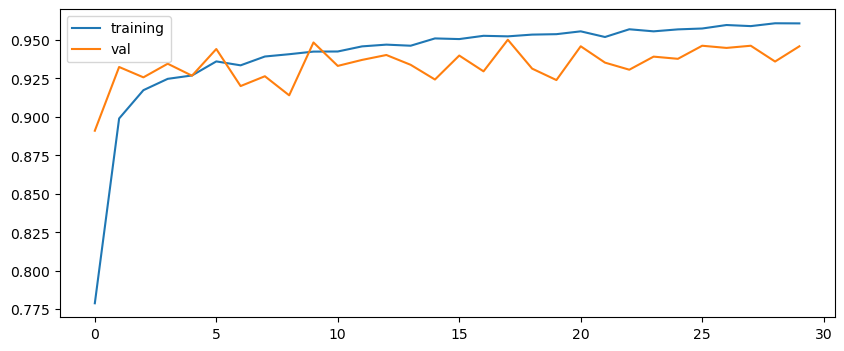

In [22]:
plt.figure(figsize=(10, 4))
plt.plot(hist["train_acc"], label="training")
plt.plot(hist["val_acc"], label="val")
plt.legend()

# Testing

Apnea Detection
              precision    recall  f1-score   support

           0      0.948     0.944     0.946     10701
           1      0.909     0.916     0.912      6547

    accuracy                          0.933     17248
   macro avg      0.929     0.930     0.929     17248
weighted avg      0.933     0.933     0.933     17248



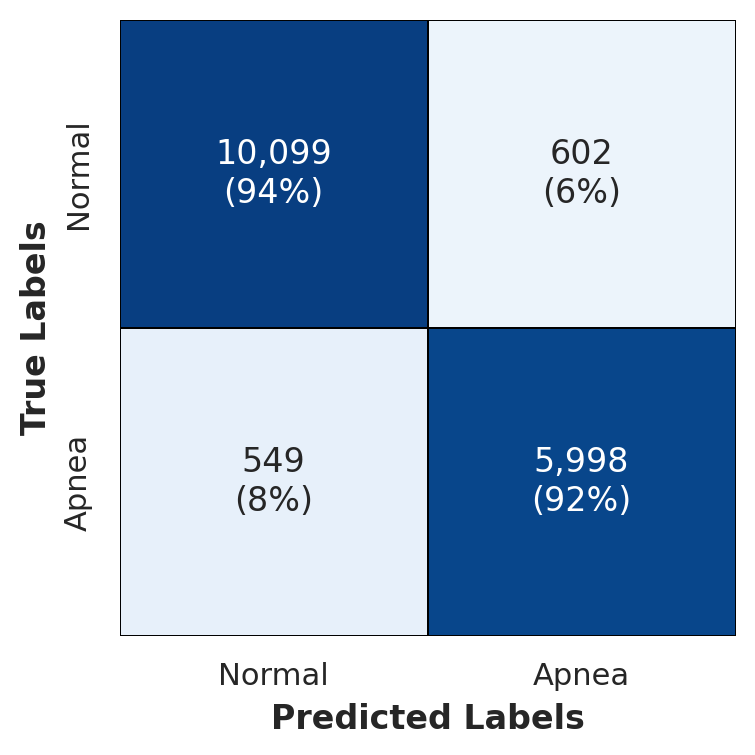

<Figure size 640x480 with 0 Axes>

In [24]:
model.eval()

# list to hold predictions
y_pred_all = []
y_true_all = []

# no grad, loop
with torch.no_grad():
    for data in dl_test:
        # to device
        X_batch = data[0].to(device)
        true = data[1].to(device).ravel()

        # zero grad
        opt.zero_grad()

        # prediction
        pred = model(X_batch)
        pred = pred.argmax(axis=-1).ravel()

        # append to the lists
        y_pred_all += pred.tolist()
        y_true_all += true.tolist()


# print metrics
print("Apnea Detection")
print(classification_report(y_true_all, y_pred_all, digits=3))

# confusion matrix
plt.figure(figsize=(4, 4), dpi=200)
plot_cm(y_true_all, y_pred_all, ["Normal", "Apnea"])
plt.show()
plt.savefig("cm.png", bbox_inches='tight', pad_inches=0)